# Estimating envelope functions

Core idea is the "isotropy principle": the marginal distributions of any $\theta$ should be the same at any chosen pitch period. But *joint* draws of $p(\theta|\alpha)$ are heavily correlated by the envelope correlation kernel $k(i,j)$ learned from real data. We assume source and filter have different envelope kernels.

Note 1: for the pitch period envelope, we can make definite predictions about jitter and shimmer values.

Determining bandwidth from formants: (Mehta & Wolfe 2015), better relation: Hawks (1995)

## Envelope learning from Praat estimates

In principle we work with fixed hyperparameters $\hat \alpha$, and predict $p(\theta|\hat\theta,\hat\alpha)$ using a conditioned Gaussian process. In other words, we do not adjust the envelope $\lambda$ or Praat estimation noise $\delta^2$ based on Praat's estimate for the data at hand.

But we could also learn the envelope from $\hat\theta$ by doing MAP over $\alpha$ starting from $\hat\alpha$ or even using nested sampling using $p(\alpha|D)$ as a prior for $\alpha$, where $D$ is the relevant TIMIT dataset. In other words, we learn the envelope parameters $\alpha$ from TIMIT and can represent this information either as a delta prior $p(\alpha|D) = \delta(\alpha-\hat\alpha)$, or retain the uncertainty, e.g. as a Gaussian $p(\alpha|D) = N(\alpha;\hat\alpha,\sigma_\alpha^2)$.

## **Relaxation**

A core theme is that we **relax** our VTR prior into a MVN Gaussian with a nonlinear transformation. This combines best of both worlds: we are strongly opiniated about what the possible VTR values could be, though stand ready to be corrected -- and we acknowledge the fact that ordering is not essential. Our relaxed VTR prior, like the original one (i.e. Pareto chain), succeeds in breaking the invariance symmetry: we need that for practical convergence of our samplers without having to fine tune the algorithm!

## Database: VTRFormants

- Subset of TIMIT where F1, F2, F3 are manually corrected.
- F4 and B1-B4 are **not** manually corrected and are just the output of a program.
- Formant trajectories are interpolated, so need specific intervention to direct Praat to actual voiced regions -- this is possible with the TIMIT information.

How to cope?

- We can just take the data as-is;
- B1-B3 can be interpolated with analytical bandwidth formulas (with injected error);
- Use tabulated $(F,B)$ data from papers (so only O(10-100) samples)

We follow the same procedure as @Hanna2016 and use @Hawks1995 empirical relationships to determine B1-3 from F1-3.
Much like we do in the LF model: we regress parameters from more fundamental ones and then fit our nonlinear coloring bijector to it.

Now the $B$ depend on $F$ *and $T$* so there is a weak coupling between source and filter -- in this case the $T$ dependence primarily captures gender/age information: bandwidths generally decrease with increasing $T$ -- see @Kent2018.

So our samples will finally be $p(x,y,F,B,T)$ and we are looking for $p(x,y|\hat F,\hat B,\hat T)$ where the hatted variables are the Praat estimates. We marginalize analytically over $F$ and $B$ to accomplish this -- see below.

## How to bootstrap $p(x,y)$

- We get the GP lengthscale from formant tracks and use that for VTRs: OK

- We can get Praat error for formants anf bandwidths: OK

- So basically we can get $p(F,B|F_o,B_o)$ relatively easily

Can we get $p(x,y|F,B)$??

$$p(x,y|F,B) = {p(F,B|x,y) p(x) p(y) \over p(F,B)}$$ Here $p(x)$ is our relaxed Pareto prior and $p(y)$ is a prior for the bandwidths. (Note that we know the normalizing constant in this problem!)

In principle $p(F,B|x,y) = \delta(F - f(x,y)) \delta(B - b(x,y))$ where $f,b$ is our peak picking algorithm. But in practice we can just use an $\exp(-E(F,B,x,y))$ where the energy $E$ is for example a mean squared error deviation $E = (F - f(x,y))^2 + (B - b(x,y))^2$ or something similar -- see [Likelihood function].

So we can fit $p(F,B)$ in the usual way, then sample from it 100 times or so and for each of these 100 samples solve the nested sampling problem for the posterior $(x,y)$ samples. In this way we have **joint samples** $(x,y,F,B)$.

**Then fit a bijector to the joint samples** in the usual way and condition on $F,B$ to get the desired $p(x,y|F,B)$.

Then we can endow trajectory structure to $p(x,y|F,B)$ in the usual way.

### The "Marginal likelihood" $p(x,y|\hat F, \hat B, \hat T)$

If given estimates $\hat F, \hat B, \hat T$, we want the marginal $p(x,y|\hat F, \hat B, \hat T)$, i.e., we don't want to separtely infer $F,B$ because that is awkward, given we that we infer them in the end from posterior samples $x,y$ and that $K_F$ may be $\neq 3$.

Just like in the source example, we just assume $T = \hat T$ so we can precalculate all the priors and never need to calculate conditional MVNs, because that may be expensive (after all it's just a prior) for speech waveforms with many pitch periods.

Luckily, we can marginalize them away analytically:
$$ p(x,y|\hat F, \hat B, \hat T) = \int\int dF dB p(x,y|F,B,\hat T) p(F,B|\hat F, \hat B) $$
The integrand contains two MVNs. This is in fact the same integration as a GP with a MVN likelihood (such as $\delta^2 I$ observation noise).
This trick means that we can **pre-calculate** the latent MVN for the $p(x,y|\hat F, \hat B)$ prior; otherwise we would need to calculate the conditional MVN $p(x,y|F, B)$ for each new value of $F,B \sim p(F,B|\hat F, \hat B)$. (But strangely enough, the covariance matrix of that conditional MVN is actually static and does not depend on $F,B$ -- but its mean does.)

### Likelihood function

Assign a Gaussian (MSE): the sigma's determine the scale.

Use typical sigma levels for formants freqs and bandwidths from literature and be more permissive (higher sigmas) for higher formants such as 2, 7, 29 Hz for F1-3 and 4, 14, 58 Hz for B1-3:

> Thus, the standard deviation
of the formant-frequency
estimates would be, roughly,
2, 7, and 29 cps for the first-, second-, and third-formant-
frequency estimates, respectively. The standard devia-
tions due to additive random noise would be roughly
4, 14, and 58 cps for the first-, second-, and third-
formant bandwidths, respectively.
Unfortunately, errors
due to other causes, such as inaccuracies
in the model,
undoubtedly are more important. (Pinson 1963)

### The number of formants

Note that the number of inferred formants $K_F$ is still dynamically inferred, but the prior is conditioned on none, one or more estimated formants. The number of estimated formants need not be the same as $K_F$; they just determine the amount of prior information ingested. Indeed: formant estimates are optional.

**Multiple posterior $K_F$'s**: in the VTR we simply hacked around this, but we should just return the estimates with their relative probabilities. E.g. 98% chance that there are three formants (and then give $F$ and $B$), 2% chance that there are four formants (and then give $F$ and $B$).

### Going further

The above procedure has to be repeated for each value of $K = |x| = |y|$ (the number of poles).
If $K = 4$, then the VTRs are forced to become formants and $p(x,y|F,B) = \delta(F - x) \delta(B - y)$.

**Hyperparameters.** The fact that we already know the normalizing constant in the above problem suggests going further. Perhaps we can optimize also over the hyperparameters of the peak picking routine.

In [1]:
%run init.ipy

from dgf.prior import period
from dgf.prior import lf
from dgf import bijectors
from lib import constants
from lib import lfmodel
from lib import klatt

import pandas as pd

import tensorflow_probability.substrates.jax.bijectors as tfb
import tensorflow_probability.substrates.jax.distributions as tfd

2022-12-08 12:31:55.157884: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-08 12:31:55.158047: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-08 12:31:55.158058: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


### Prior mean and coveriances for the VTR frequencies

Estimation of prior mean and covariances for the VTR frequencies in the latent log space. Notes:
- The latent MVN in log space is highly correlated and encodes approximately the ordering of the VTRs;
- This correlation should be taken into account (and it strongly breaks the symmetry like our VTR prior)
- The latent MVN in log space underestimates the fat tails of the true distribution of `p(log x)` (which looks similar to a Landau distribution). Thus the VTR frequencies tend to be shy of higher frequencies (say > 2000 Hz). I don't think this will be a problem, as there is still mass at these higher frequencies, but if this turns out to be one, we could apply a FITC-like diagonal correction to the covariance matrix.
- We don't use the pdf weights in estimating the mean and covariance matrices because the correct pdfs of the *truncated* distribution `sample_truncated()` require to evaluate an integral that I don't have time to evaluate
- **Units.** Our log log transformation is not fully kosher because we are log transforming quantities which are not dimensionless. It is indeed possible to do this more properly by log transforming ratios of successive VTR frequencies, as in the Pareto chain prior, but then we cannot guarantee anymore the "isotropy principle", i.e., that the marginal means and variances are constant and do not depend on the particular pitch period chosen. I've also seen MacKay do this, so it's not too bad.

In [6]:
from vtr.prior import pareto as paretochain
from dynesty import utils as dyfunc
from dgf import bijectors

def getx(nx, x0, fs, size=1):
    xmax = fs/2
    xbar = x0 + (xmax - x0)/(nx+1)*np.arange(1, nx+1)
    #xbar = 500*np.arange(1, nx+1)
    x = paretochain.sample_x_truncated(np.array([x0, *xbar]), xmax, size=size)
    return x

size = int(1e5) # 1e5
npoles = 4
x0 = 100/1000
fs = 10000/1000

x = getx(npoles, x0, fs, size) # (n, npoles)
bounds = np.vstack([[x0, fs/2]]*npoles)

# npoles = 4 => cacheid=11723 -- takes # O(1) minutes
# npoles = 10 => cacheid=78238-- takes # O(50) minutes
b = bijectors.fit_nonlinear_coloring_bijector(x, bounds, 11723)

________________________________________________________________________________
[Memory] Calling dgf.bijectors.run_nested...
run_nested(11723, {'nlive': 20}, {'save_bounds': False})


662it [00:39, 16.79it/s, +20 | bound: 165 | nc: 1 | ncall: 6744 | eff(%): 10.143 | loglstar:   -inf < 210800.877 <    inf | logz: 210772.147 +/-  1.141 | dlogz:  0.001 >  0.029]


______________________________________________________run_nested - 46.5s, 0.8min


DeviceArray([0.20889166, 0.32849115, 0.40852415, 0.48626279], dtype=float64)

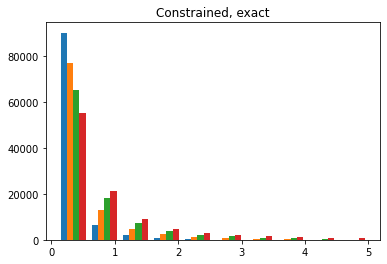

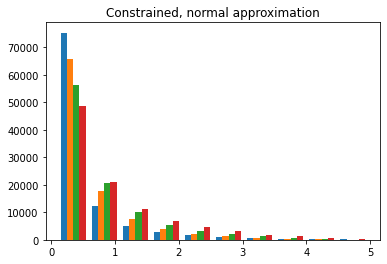

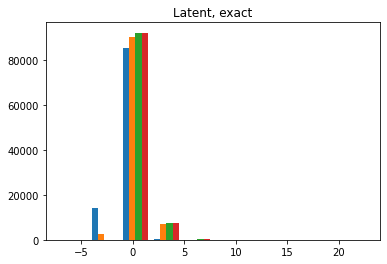

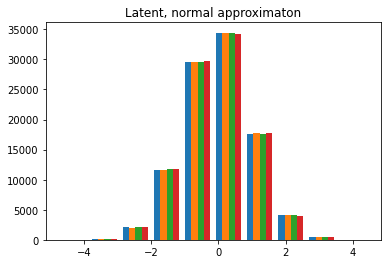

In [7]:
y = asarray(b.inverse(x)) # Latent

ya = randn(size, npoles)
xa = b.forward(ya)

figure()
title("Constrained, exact")
hist(x, bins=10);

figure()
title("Constrained, normal approximation");
hist(asarray(xa), bins=10);

figure()
title("Latent, exact")
hist(y);

figure()
title("Latent, normal approximaton")
hist(ya);

# Sample from the normal approximation
xa[randint(size),:]

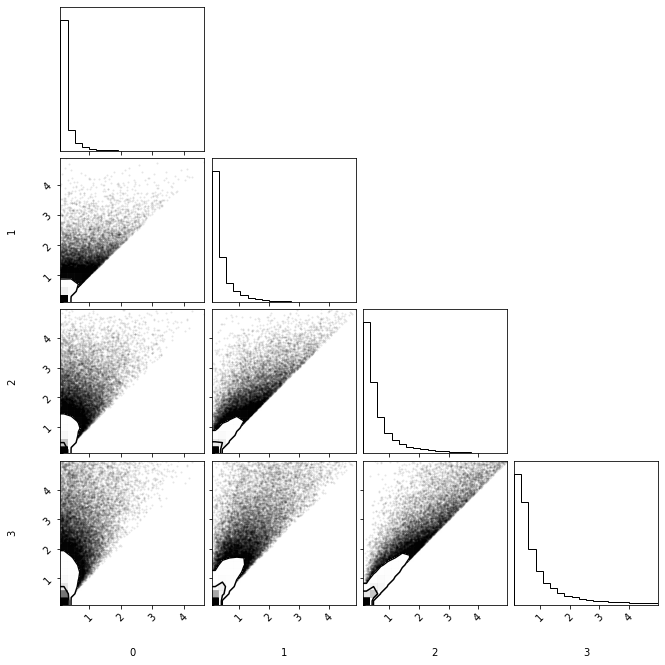

In [8]:
import corner
corner.corner(x, labels=arange(x.shape[1]));

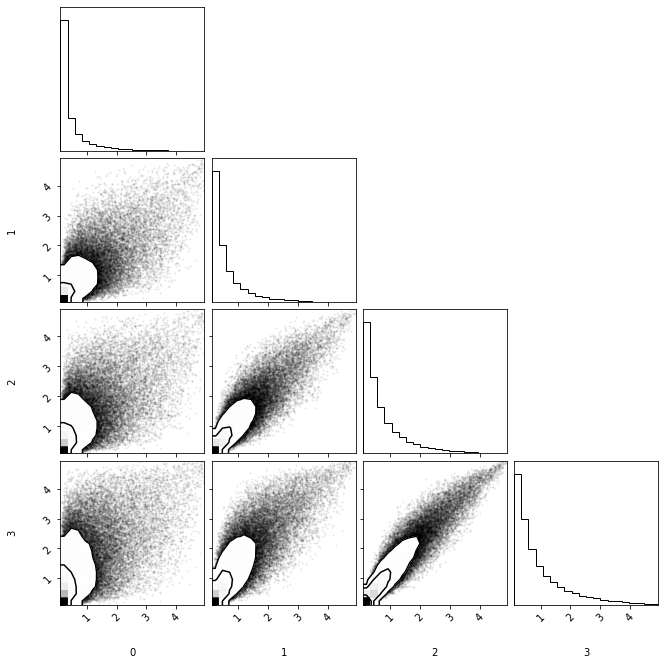

In [9]:
corner.corner(np.array(xa), labels=arange(x.shape[1]));

### VTR frequency trajectories

The covariance function $k([r,i],[s,j]) = k(r,s) k(i,j)$ has Kronecker structure. $k(r,s)$ is the covariance between VTR with indices $r$ and $s$. $k(i,j)$ is the *correlation* (i.e., has unit marginal variance) envelope.

In [10]:
envelope_kernel_name = "SqExponentialKernel"
envelope_lengthscale = 70.
num_pitch_periods = 100

btraj = bijectors.nonlinear_coloring_trajectory_bijector(
    b,
    num_pitch_periods,
    envelope_kernel_name,
    envelope_lengthscale
)

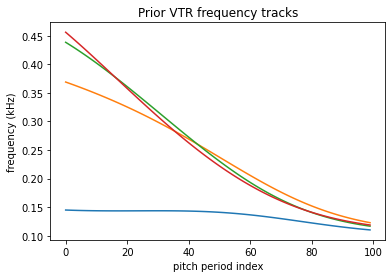

In [11]:
z = randn(npoles*num_pitch_periods)
plot(btraj.forward(z))
title('Prior VTR frequency tracks')
xlabel('pitch period index')
ylabel('frequency (kHz)');

## Check conditioning

In [15]:
%%time
def randz(): return randn(npoles*num_pitch_periods)

observation = btraj.forward(randz())

cbtraj = bijectors.condition_nonlinear_coloring_trajectory_bijector(
    btraj,
    observation,
    np.eye(npoles)*0.1 # IID noise
)

CPU times: user 93.9 ms, sys: 15.9 ms, total: 110 ms
Wall time: 169 ms


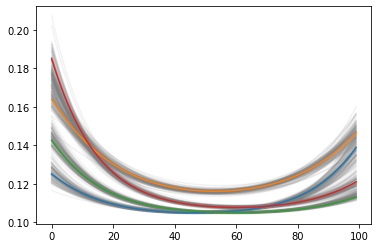

In [17]:
shown = [0, 1, 2, 3]

for _ in range(100):
    plot(cbtraj.forward(randz())[:,shown], color="grey", alpha=.1);
    
plot(observation[:,shown])

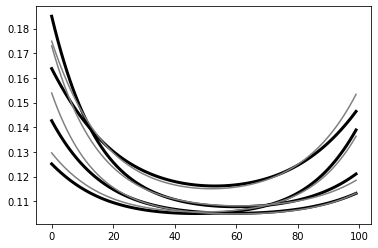

In [20]:
x = observation
y = cbtraj.forward(randz())

plot(x, lw=3, color="black")
plot(y, color="grey");

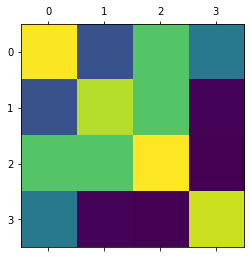

In [21]:
C = bijectors.estimate_observation_noise_cov(
    cbtraj,
    [x, x], [y, y]
)

matshow(C)

In [22]:
cbtraj_cov = bijectors.condition_nonlinear_coloring_trajectory_bijector(
    btraj,
    observation,
    C
)

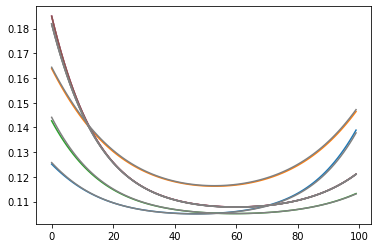

In [23]:
shown = [0, 1, 2, 3, 8, 9]

plot(x[:,shown])

plot(cbtraj_cov.forward(randz())[:,shown], color="grey");

In [27]:
cbtraj_cov.forward(randz())[:,shown]

DeviceArray([[0.12611692, 0.16234476, 0.1426215 , 0.18581426, 0.18581426,
              0.18581426],
             [0.12472128, 0.15999529, 0.14030798, 0.18071821, 0.18071821,
              0.18071821],
             [0.12340133, 0.1577365 , 0.13812137, 0.17591314, 0.17591314,
              0.17591314],
             [0.12215413, 0.15556669, 0.136056  , 0.17138644, 0.17138644,
              0.17138644],
             [0.12097672, 0.15348344, 0.13410641, 0.16712568, 0.16712568,
              0.16712568],
             [0.11986615, 0.15148483, 0.13226719, 0.16311834, 0.16311834,
              0.16311834],
             [0.11881948, 0.14956861, 0.13053305, 0.15935233, 0.15935233,
              0.15935233],
             [0.1178338 , 0.14773244, 0.12889877, 0.15581568, 0.15581568,
              0.15581568],
             [0.11690631, 0.14597418, 0.12735951, 0.1524968 , 0.1524968 ,
              0.1524968 ],
             [0.11603415, 0.14429153, 0.12591032, 0.14938424, 0.14938424,
              0.1

## Convolve with LF

The lsim() computation becomes unstable for 10 poles and it works well for 4 poles.

Idea to get good freqs and bandwidths: Measure freq and bandwidths trajectories from Praat, then sample from the trajectories conditioned on them. 

In [17]:
from dgf import isokernels
from lib import lfmodel

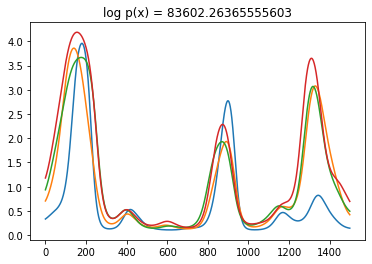

In [18]:
envelope_kernel_name = "SqExponentialKernel"
envelope_lengthscale = 70.
num_pitch_periods = 1500

btraj = bijectors.nonlinear_coloring_trajectory_bijector(
    b,
    num_pitch_periods,
    envelope_kernel_name,
    envelope_lengthscale
)

standardnormals = tfd.MultivariateNormalDiag(scale_diag=jnp.ones(npoles*num_pitch_periods))
vtrprior = tfd.TransformedDistribution(
    distribution=standardnormals,
    bijector=btraj
)

x, log_prob_x = vtrprior.experimental_sample_and_log_prob(seed=jaxkey())

plot(x)
title(f"log p(x) = {log_prob_x}");

In [19]:
envelope_kernel_name = 'Matern32Kernel'
envelope_lengthscale = 100.

prior = lf.generic_params_trajectory_prior(
    num_pitch_periods,
    envelope_kernel_name,
    envelope_lengthscale,
    envelope_noise_sigma = 0. # Setting this to 0. is crucial, otherwise
)                             # very breathy sound

t, u, log_prob_u, context = lf.sample_and_log_prob_dgf(
    prior, jaxkey(1111), num_pitch_periods, return_full=True,
    noise_floor_power=0. # Causes Non-finite log likelihood, otherwise doesnt
)                        # affect sound

[Memory]656.8s, 10.9min : Loading sample_lf_params...
[Memory]657.1s, 11.0min : Loading run_nested...


/home/marnix/WRK/thesis/py/dgf/prior/lf.py:493: UserWarning: Non-finite log likelihood at period indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200

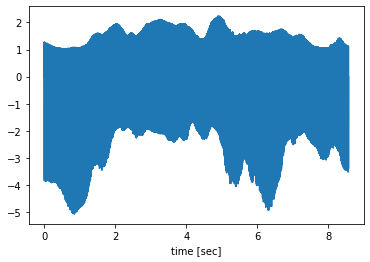

In [20]:
plot(t/1000, u)
xlabel("time [sec]");

from lib import klatt
klatt.play(t, u)

In [21]:
import scipy.signal
from dgf import core

from dgf.prior import source

def support(t, T0, offset=0., pre=0, post=1):
    i = lf._nonzero_dgf_indices(t - offset, T0)
    a = max(i[0] - len(i)*pre, 0)
    b = min(i[0] + len(i)*(1+post), len(t))
    return a, b

def convolve(i, ui, xi, t, p, start, end):
    """This can be made JAX-compatible with `jax.scipy.linalg.expm()`, as `lsim()` uses `expm()`"""
    # For a real speedup maybe use `scipy.signal.cont2discrete()` and then just `jax.convolve`
    a, b = support(
        t, p['T0'][i], offset=t[start],
        pre=0, post=10 # You need 10 if you really want to capture everything
    )
    ut = np.zeros_like(t)
    ut[start:end] = ui
    uu = ut[a:b]
    tt = t[a:b]
    
    # Formant bandwidths
    # followed the relation bandwidth = 80 + 120*frequency/5000 (Mehta & Wolfe 2015)
    # Better relation: Hawks (1995)
    freqs = xi*1000
    bandwidths = 80 + 120*freqs/5000
    q = core.make_poles(bandwidths, freqs)

    zeros = np.array([])
    poles = np.hstack([q, np.conj(q)])
    gain = np.prod(np.abs(q)**2)

    print(i, end=" ")
    T, y, _ = scipy.signal.lsim((zeros, poles, gain), uu, tt)
    out = np.zeros_like(t)
    out[a:b] = y
    return out

p = context['p']
us = context['us']
t = np.array(t)
start, end = context['start'], context['end']

conv = np.array([convolve(i, ui, xi, t, p, start[i], end[i]) for i, (xi, ui) in enumerate(zip(x, us))])
out = np.nansum(conv, axis=0)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 

/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/scipy/sparse/linalg/_matfuncs.py:708: LinAlgWarning: Ill-conditioned matrix (rcond=1.02653e-16): result may not be accurate.
  return solve(Q, P)
/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/scipy/sparse/linalg/_matfuncs.py:708: LinAlgWarning: Ill-conditioned matrix (rcond=8.7332e-17): result may not be accurate.
  return solve(Q, P)
/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/scipy/sparse/linalg/_matfuncs.py:708: LinAlgWarning: Ill-conditioned matrix (rcond=7.45346e-17): result may not be accurate.
  return solve(Q, P)
/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/scipy/sparse/linalg/_matfuncs.py:708: LinAlgWarning: Ill-conditioned matrix (rcond=6.38222e-17): result may not be accurate.
  return solve(Q, P)
/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/scipy/sparse/linalg/_matfuncs.py:708: LinAlgWarning: Ill-conditioned matrix (rcond=5.48339e-17): result may not be ac

123 124 125 126 127 

/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/scipy/sparse/linalg/_matfuncs.py:708: LinAlgWarning: Ill-conditioned matrix (rcond=4.72754e-17): result may not be accurate.
  return solve(Q, P)
/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/scipy/sparse/linalg/_matfuncs.py:708: LinAlgWarning: Ill-conditioned matrix (rcond=1.04755e-16): result may not be accurate.
  return solve(Q, P)
/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/scipy/sparse/linalg/_matfuncs.py:708: LinAlgWarning: Ill-conditioned matrix (rcond=4.09029e-17): result may not be accurate.
  return solve(Q, P)
/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/scipy/sparse/linalg/_matfuncs.py:708: LinAlgWarning: Ill-conditioned matrix (rcond=9.15788e-17): result may not be accurate.
  return solve(Q, P)
/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/scipy/sparse/linalg/_matfuncs.py:708: LinAlgWarning: Ill-conditioned matrix (rcond=3.55188e-17): result may not be a

128 129 130 131 132 133 

/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/scipy/sparse/linalg/_matfuncs.py:708: LinAlgWarning: Ill-conditioned matrix (rcond=2.09551e-17): result may not be accurate.
  return solve(Q, P)
/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/scipy/sparse/linalg/_matfuncs.py:708: LinAlgWarning: Ill-conditioned matrix (rcond=4.92924e-17): result may not be accurate.
  return solve(Q, P)
/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/scipy/sparse/linalg/_matfuncs.py:708: LinAlgWarning: Ill-conditioned matrix (rcond=1.85429e-17): result may not be accurate.
  return solve(Q, P)
/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/scipy/sparse/linalg/_matfuncs.py:708: LinAlgWarning: Ill-conditioned matrix (rcond=4.40305e-17): result may not be accurate.
  return solve(Q, P)
/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/scipy/sparse/linalg/_matfuncs.py:708: LinAlgWarning: Ill-conditioned matrix (rcond=1.64714e-17): result may not be a

134 135 136 137 138 139 140 

/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/scipy/sparse/linalg/_matfuncs.py:708: LinAlgWarning: Ill-conditioned matrix (rcond=3.81651e-17): result may not be accurate.
  return solve(Q, P)
/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/scipy/sparse/linalg/_matfuncs.py:708: LinAlgWarning: Ill-conditioned matrix (rcond=2.42492e-17): result may not be accurate.
  return solve(Q, P)
/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/scipy/sparse/linalg/_matfuncs.py:708: LinAlgWarning: Ill-conditioned matrix (rcond=3.47105e-17): result may not be accurate.
  return solve(Q, P)
/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/scipy/sparse/linalg/_matfuncs.py:708: LinAlgWarning: Ill-conditioned matrix (rcond=2.22571e-17): result may not be accurate.
  return solve(Q, P)
/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/scipy/sparse/linalg/_matfuncs.py:708: LinAlgWarning: Ill-conditioned matrix (rcond=3.16942e-17): result may not be a

141 142 143 144 145 146 147 

/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/scipy/sparse/linalg/_matfuncs.py:708: LinAlgWarning: Ill-conditioned matrix (rcond=2.13432e-17): result may not be accurate.
  return solve(Q, P)
/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/scipy/sparse/linalg/_matfuncs.py:708: LinAlgWarning: Ill-conditioned matrix (rcond=1.44458e-17): result may not be accurate.
  return solve(Q, P)
/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/scipy/sparse/linalg/_matfuncs.py:708: LinAlgWarning: Ill-conditioned matrix (rcond=1.99515e-17): result may not be accurate.
  return solve(Q, P)
/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/scipy/sparse/linalg/_matfuncs.py:708: LinAlgWarning: Ill-conditioned matrix (rcond=1.3624e-17): result may not be accurate.
  return solve(Q, P)
/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/scipy/sparse/linalg/_matfuncs.py:708: LinAlgWarning: Ill-conditioned matrix (rcond=1.87215e-17): result may not be ac

148 149 150 151 152 153 

/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/scipy/sparse/linalg/_matfuncs.py:708: LinAlgWarning: Ill-conditioned matrix (rcond=1.50542e-17): result may not be accurate.
  return solve(Q, P)
/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/scipy/sparse/linalg/_matfuncs.py:708: LinAlgWarning: Ill-conditioned matrix (rcond=1.07453e-17): result may not be accurate.
  return solve(Q, P)
/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/scipy/sparse/linalg/_matfuncs.py:708: LinAlgWarning: Ill-conditioned matrix (rcond=1.43851e-17): result may not be accurate.
  return solve(Q, P)
/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/scipy/sparse/linalg/_matfuncs.py:708: LinAlgWarning: Ill-conditioned matrix (rcond=1.03581e-17): result may not be accurate.
  return solve(Q, P)
/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/scipy/sparse/linalg/_matfuncs.py:708: LinAlgWarning: Ill-conditioned matrix (rcond=1.37938e-17): result may not be a

154 155 156 157 158 159 160 

/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/scipy/sparse/linalg/_matfuncs.py:708: LinAlgWarning: Ill-conditioned matrix (rcond=1.1755e-17): result may not be accurate.
  return solve(Q, P)
/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/scipy/sparse/linalg/_matfuncs.py:708: LinAlgWarning: Ill-conditioned matrix (rcond=8.92015e-18): result may not be accurate.
  return solve(Q, P)
/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/scipy/sparse/linalg/_matfuncs.py:708: LinAlgWarning: Ill-conditioned matrix (rcond=1.14948e-17): result may not be accurate.
  return solve(Q, P)
/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/scipy/sparse/linalg/_matfuncs.py:708: LinAlgWarning: Ill-conditioned matrix (rcond=8.79952e-18): result may not be accurate.
  return solve(Q, P)
/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/scipy/sparse/linalg/_matfuncs.py:708: LinAlgWarning: Ill-conditioned matrix (rcond=1.12755e-17): result may not be ac

161 162 163 164 165 166 

/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/scipy/sparse/linalg/_matfuncs.py:708: LinAlgWarning: Ill-conditioned matrix (rcond=1.07563e-17): result may not be accurate.
  return solve(Q, P)
/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/scipy/sparse/linalg/_matfuncs.py:708: LinAlgWarning: Ill-conditioned matrix (rcond=8.60172e-18): result may not be accurate.
  return solve(Q, P)
/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/scipy/sparse/linalg/_matfuncs.py:708: LinAlgWarning: Ill-conditioned matrix (rcond=1.07085e-17): result may not be accurate.
  return solve(Q, P)
/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/scipy/sparse/linalg/_matfuncs.py:708: LinAlgWarning: Ill-conditioned matrix (rcond=8.63801e-18): result may not be accurate.
  return solve(Q, P)
/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/scipy/sparse/linalg/_matfuncs.py:708: LinAlgWarning: Ill-conditioned matrix (rcond=1.06901e-17): result may not be a

167 168 169 170 171 172 

/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/scipy/sparse/linalg/_matfuncs.py:708: LinAlgWarning: Ill-conditioned matrix (rcond=1.08145e-17): result may not be accurate.
  return solve(Q, P)
/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/scipy/sparse/linalg/_matfuncs.py:708: LinAlgWarning: Ill-conditioned matrix (rcond=9.03393e-18): result may not be accurate.
  return solve(Q, P)
/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/scipy/sparse/linalg/_matfuncs.py:708: LinAlgWarning: Ill-conditioned matrix (rcond=1.09157e-17): result may not be accurate.
  return solve(Q, P)
/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/scipy/sparse/linalg/_matfuncs.py:708: LinAlgWarning: Ill-conditioned matrix (rcond=9.19849e-18): result may not be accurate.
  return solve(Q, P)
/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/scipy/sparse/linalg/_matfuncs.py:708: LinAlgWarning: Ill-conditioned matrix (rcond=1.10481e-17): result may not be a

173 174 175 176 177 178 

/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/scipy/sparse/linalg/_matfuncs.py:708: LinAlgWarning: Ill-conditioned matrix (rcond=1.19067e-17): result may not be accurate.
  return solve(Q, P)
/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/scipy/sparse/linalg/_matfuncs.py:708: LinAlgWarning: Ill-conditioned matrix (rcond=1.04813e-17): result may not be accurate.
  return solve(Q, P)
/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/scipy/sparse/linalg/_matfuncs.py:708: LinAlgWarning: Ill-conditioned matrix (rcond=1.2214e-17): result may not be accurate.
  return solve(Q, P)
/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/scipy/sparse/linalg/_matfuncs.py:708: LinAlgWarning: Ill-conditioned matrix (rcond=1.08451e-17): result may not be accurate.
  return solve(Q, P)
/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/scipy/sparse/linalg/_matfuncs.py:708: LinAlgWarning: Ill-conditioned matrix (rcond=1.25634e-17): result may not be ac

179 180 181 182 183 

/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/scipy/sparse/linalg/_matfuncs.py:708: LinAlgWarning: Ill-conditioned matrix (rcond=1.38994e-17): result may not be accurate.
  return solve(Q, P)
/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/scipy/sparse/linalg/_matfuncs.py:708: LinAlgWarning: Ill-conditioned matrix (rcond=1.27708e-17): result may not be accurate.
  return solve(Q, P)
/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/scipy/sparse/linalg/_matfuncs.py:708: LinAlgWarning: Ill-conditioned matrix (rcond=1.44558e-17): result may not be accurate.
  return solve(Q, P)
/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/scipy/sparse/linalg/_matfuncs.py:708: LinAlgWarning: Ill-conditioned matrix (rcond=1.33949e-17): result may not be accurate.
  return solve(Q, P)
/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/scipy/sparse/linalg/_matfuncs.py:708: LinAlgWarning: Ill-conditioned matrix (rcond=1.50773e-17): result may not be a

184 185 186 187 188 

/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/scipy/sparse/linalg/_matfuncs.py:708: LinAlgWarning: Ill-conditioned matrix (rcond=1.74037e-17): result may not be accurate.
  return solve(Q, P)
/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/scipy/sparse/linalg/_matfuncs.py:708: LinAlgWarning: Ill-conditioned matrix (rcond=1.66793e-17): result may not be accurate.
  return solve(Q, P)
/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/scipy/sparse/linalg/_matfuncs.py:708: LinAlgWarning: Ill-conditioned matrix (rcond=1.83654e-17): result may not be accurate.
  return solve(Q, P)
/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/scipy/sparse/linalg/_matfuncs.py:708: LinAlgWarning: Ill-conditioned matrix (rcond=1.77495e-17): result may not be accurate.
  return solve(Q, P)
/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/scipy/sparse/linalg/_matfuncs.py:708: LinAlgWarning: Ill-conditioned matrix (rcond=1.94383e-17): result may not be a

189 190 191 192 193 

/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/scipy/sparse/linalg/_matfuncs.py:708: LinAlgWarning: Ill-conditioned matrix (rcond=2.34941e-17): result may not be accurate.
  return solve(Q, P)
/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/scipy/sparse/linalg/_matfuncs.py:708: LinAlgWarning: Ill-conditioned matrix (rcond=2.34912e-17): result may not be accurate.
  return solve(Q, P)
/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/scipy/sparse/linalg/_matfuncs.py:708: LinAlgWarning: Ill-conditioned matrix (rcond=2.51922e-17): result may not be accurate.
  return solve(Q, P)
/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/scipy/sparse/linalg/_matfuncs.py:708: LinAlgWarning: Ill-conditioned matrix (rcond=2.54065e-17): result may not be accurate.
  return solve(Q, P)
/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/scipy/sparse/linalg/_matfuncs.py:708: LinAlgWarning: Ill-conditioned matrix (rcond=2.71095e-17): result may not be a

194 195 196 197 198 

/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/scipy/sparse/linalg/_matfuncs.py:708: LinAlgWarning: Ill-conditioned matrix (rcond=3.45416e-17): result may not be accurate.
  return solve(Q, P)
/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/scipy/sparse/linalg/_matfuncs.py:708: LinAlgWarning: Ill-conditioned matrix (rcond=3.60485e-17): result may not be accurate.
  return solve(Q, P)
/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/scipy/sparse/linalg/_matfuncs.py:708: LinAlgWarning: Ill-conditioned matrix (rcond=3.7744e-17): result may not be accurate.
  return solve(Q, P)
/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/scipy/sparse/linalg/_matfuncs.py:708: LinAlgWarning: Ill-conditioned matrix (rcond=3.97279e-17): result may not be accurate.
  return solve(Q, P)
/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/scipy/sparse/linalg/_matfuncs.py:708: LinAlgWarning: Ill-conditioned matrix (rcond=4.14167e-17): result may not be ac

199 200 201 202 203 

/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/scipy/sparse/linalg/_matfuncs.py:708: LinAlgWarning: Ill-conditioned matrix (rcond=5.61962e-17): result may not be accurate.
  return solve(Q, P)
/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/scipy/sparse/linalg/_matfuncs.py:708: LinAlgWarning: Ill-conditioned matrix (rcond=6.11952e-17): result may not be accurate.
  return solve(Q, P)
/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/scipy/sparse/linalg/_matfuncs.py:708: LinAlgWarning: Ill-conditioned matrix (rcond=6.28052e-17): result may not be accurate.
  return solve(Q, P)
/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/scipy/sparse/linalg/_matfuncs.py:708: LinAlgWarning: Ill-conditioned matrix (rcond=6.89737e-17): result may not be accurate.
  return solve(Q, P)
/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/scipy/sparse/linalg/_matfuncs.py:708: LinAlgWarning: Ill-conditioned matrix (rcond=7.05479e-17): result may not be a

204 205 206 207 

/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/scipy/sparse/linalg/_matfuncs.py:708: LinAlgWarning: Ill-conditioned matrix (rcond=1.03248e-16): result may not be accurate.
  return solve(Q, P)


208 209 210 211 212 213 214 215 216 

/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/scipy/sparse/linalg/_matfuncs.py:708: LinAlgWarning: Ill-conditioned matrix (rcond=7.90356e-17): result may not be accurate.
  return solve(Q, P)
/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/scipy/sparse/linalg/_matfuncs.py:708: LinAlgWarning: Ill-conditioned matrix (rcond=9.52086e-17): result may not be accurate.
  return solve(Q, P)


217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376 377 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400 401 402 403 404 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466 

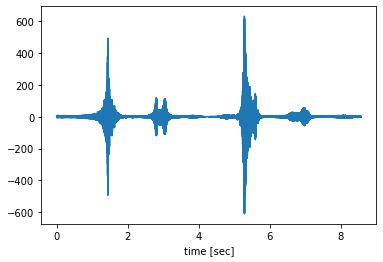

In [22]:
plot(t/1000, out)
xlabel("time [sec]");

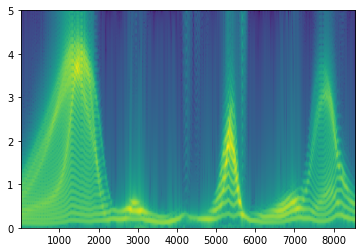

In [23]:
specgram(out, Fs=fs);

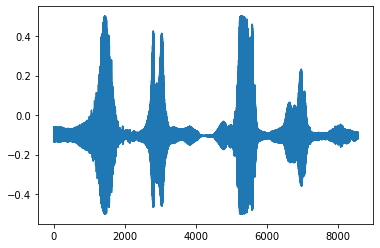

In [24]:
def compress(a, factor=.85):
    from scipy.special import expit
    m, s = np.mean(a), np.std(a)
    x = (a - m)/s
    return expit((x - 0.5)*factor) - 0.5
        
plot(t, compress(out))
klatt.play(t, compress(out))

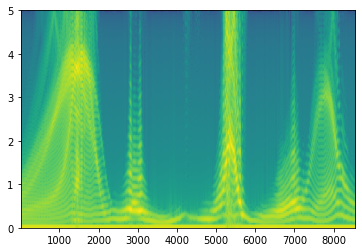

In [25]:
specgram(compress(out), Fs=fs);